# Twice Denoising Autoencoder (TDAE)

In [2]:
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, BatchNormalization, average, Conv1D, Conv2D, ReLU
from tensorflow.keras.models import Model, load_model, Sequential, model_from_json
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
import math
import scipy.io
import h5py
import tensorflow as tf
import numpy as np
import matlab.engine
from datetime import datetime

# start matlab engine
eng = matlab.engine.start_matlab()


## 1. Function defination

In [3]:
# 2D/3D local correlation 
def corr(a, b):
    a = a - mean(a)
    b = b - mean(b)
    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r
def mean(x): 
    y = np.sum(x) / np.size(x);
    return y
def lcc(nd, d, wlen):
    if d.ndim == 2:
        wlen1 = wlen[0]
        wlen2 = wlen[1]
        m, n = nd.shape[0], nd.shape[1]
        lamb = np.zeros([m, n])
        temp1 = np.zeros([m+wlen1-1, n+wlen2-1])
        temp2 = np.zeros([m+wlen1-1, n+wlen2-1])
        start1 = int((wlen1-1)/2)
        start2 = int((wlen2-1)/2)
        # output
        temp1[start1:start1+m, start2:start2+n] = d
        # noise
        temp2[start1:start1+m, start2:start2+n] = nd - d
        
        k1 = 0
        for i in range(start1, start1+m):
            # print(i)
            k2 = 0
            for j in range(start2, start2+n):
                # print(j)
                w1 = temp1[i-start1:i+start1, j-start2:j+start2]
                w2 = temp2[i-start1:i+start1, j-start2:j+start2]
                lamb[k1, k2] = corr(w1, w2)
                k2 = k2 + 1
            k1 = k1 + 1

    if d.ndim == 3:
        wlen1 = wlen[0]
        wlen2 = wlen[1]
        wlen3 = wlen[2]
        m, n, o = nd.shape[0], nd.shape[1], nd.shape[2]
        lamb = np.zeros([m, n, o])
        temp1 = np.zeros([m+wlen1-1, n+wlen2-1, o+wlen3-1])
        temp2 = np.zeros([m+wlen1-1, n+wlen2-1, o+wlen3-1])
        start1 = int((wlen1-1)/2)
        start2 = int((wlen2-1)/2)
        start3 = int((wlen3-1)/2)
        # output
        temp1[start1:start1+m, start2:start2+n, start3:start3+o] = d
        # noise
        temp2[start1:start1+m, start2:start2+n, start3:start3+o] = nd - d
        
        k1 = 0
        for i in range(start1, start1+m):
            # print(i)
            k2 = 0
            for j in range(start2, start2+n):
                # print(j)
                k3 = 0
                for k in range(start3, start3+o):
                    # print(k)
                    w1 = temp1[i-start1:i+start1, j-start2:j+start2, k-start3:k+start3]
                    w2 = temp2[i-start1:i+start1, j-start2:j+start2, k-start3:k+start3]
                    lamb[k1, k2, k3] = corr(w1, w2)
                    k3 = k3 + 1
                k2 = k2 + 1
            k1 = k1 + 1
      
    return lamb

# Nonlinear mapping
def nonlinear_map(d):
    if d.ndim == 2:
        m, n = d.shape
        d1 = np.zeros(shape=(m,n))
        d = (d + abs(d))/2
        d = (d - d.min())/(d.max() - d.min())

        for i in range(m):
            for j in range(n):
                d1[i][j] = (1 + math.atan(d[i][j]*10-5)/math.atan(d.max()*10-5))/2
                
    if d.ndim == 3:
        m, n, o = d.shape
        d1 = np.zeros(shape=(m,n,o))
        d = (d + abs(d))/2
        d = (d - d.min())/(d.max() - d.min())

        for i in range(m):
            for j in range(n):
                for k in range(o):
                    d1[i][j][k] = (1 + math.atan(d[i][j][k]*10-5)/math.atan(d.max()*10-5))/2

    return d1

# add gaussion noise
def add_noise(signal, SNR, seed):
    if signal.ndim == 2:
        np.random.seed(seed)
        noise = np.random.randn(signal.shape[0],signal.shape[1])

    if signal.ndim == 3:
        np.random.seed(seed)
        noise = np.random.randn(signal.shape[0],signal.shape[1],signal.shape[2])

    noise = noise-np.mean(noise)
    signal_power = np.linalg.norm( signal - signal.mean() )**2 / signal.size
    noise_variance = signal_power/np.power(10,(SNR/10))
    noise = (np.sqrt(noise_variance) / np.std(noise) )*noise
    signal_noise = noise + signal
    
    return signal_noise

# SNR
def snr(signal, noisy):
    error = signal - noisy
    temp1 = np.sum(np.sum(signal*signal))
    temp2 = np.sum(np.sum(error*error))
    snr = 10*np.log10(temp1/temp2)
    
    return snr

# Function in Matlab
def patching(ndata, parameter):
    scipy.io.savemat('./input.mat', mdict={'ndata': ndata})
    eng.patching(matlab.double(parameter),nargout=0)
    f = scipy.io.loadmat('./input_patched.mat')
    ndata_patch = f['nd_patched'][:]

    # Random Permute for the patches for training
    ind = np.random.permutation(len(ndata_patch))
    ndata_patch = np.array(ndata_patch)
    ndata_patch_train = ndata_patch[ind]
    
    return ndata_patch, ndata_patch_train

def unpatching(out,parameter):
    scipy.io.savemat('./output_patched.mat', mdict={'d_patched': out})
    eng.unpatching(matlab.double(parameter),nargout=0)
    f = scipy.io.loadmat('./output.mat')
    data = f['data'][:]
    return data

def nlcc_matlab(ndata, data, wlen):
    # cormat=lcc(ndata,data, wlen)   
    scipy.io.savemat('./data_for_NLC.mat', mdict={'ndata': ndata,'data': data})
    lamb = eng.nlcc(matlab.double(wlen),nargout=1)
    
    return lamb


## 2.Data preparation

Field data
(200, 200)


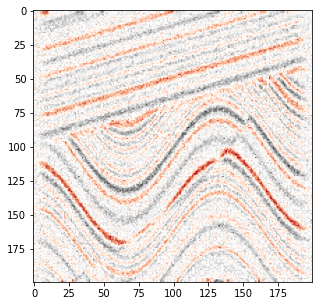

In [9]:
dname = 'sigmoid_nd'
nd = h5py.File('./data/'+dname+'.mat', 'r')
ndata = nd['nd'][:]
ndata = ndata.transpose()
print('Field data')
print(ndata.shape)
    
# draw
if ndata.ndim == 2:
    plt.figure(figsize=[5,5])
    plt.imshow(ndata,aspect='auto',cmap='RdGy')

## 3. Definations of DAE and TDAE

In [11]:
# DAE
def DAE(input_size, neural_num = 128):

    input_img = Input(shape=(input_size,))
    
    encoded1 = Dense(neural_num,  activation='elu')(input_img)
    encoded2 = Dense(neural_num/2,  activation='elu')(encoded1)
    encoded3 = Dense(neural_num/4,  activation='elu' )(encoded2)
    encoded4 = Dense(neural_num/8,  activation='elu' )(encoded3)
    
    code = Dense(neural_num/16,  activation='elu' )(encoded4)

    decoded1 = Dense(neural_num/8,  activation='elu' )(code)
    decoded1 = concatenate([decoded1,encoded4])
    decoded2 = Dense(neural_num/4,  activation='elu')(decoded1)
    decoded2 = concatenate([decoded2,encoded3])
    decoded3 = Dense(neural_num/2,  activation='elu' )(decoded2)
    decoded3 = concatenate([decoded3,encoded2])
    decoded4 = Dense(neural_num,  activation='elu' )(decoded3)
    decoded4 = concatenate([decoded4,encoded1])

    decoded = Dense(input_size, activation='linear')(decoded4)
    
    autoencoder = Model(input_img, decoded)
    
    return autoencoder

def Train_DAE(ndata,patch_parameter,neural_num):
    # patching
    ndata = ndata.astype(np.float32)
    tic = datetime.now()
    ndata_patch, ndata_patch_train = patching(ndata,patch_parameter)
    toc = datetime.now()
    print('patch time consumption:')
    print(toc-tic)
    
    sgd = optimizers.Adam(lr=0.001)
    autoencoder = DAE(ndata_patch.shape[1],neural_num)
    
    # autoencoder.compile(optimizer=sgd, loss=[myloss])
    autoencoder.compile(optimizer=sgd, loss='mse')
    # autoencoder.summary()

    es=EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=10)
    mc=ModelCheckpoint('best_DAEmodel.h5',monitor='val_loss',mode='min',save_best_only=True)
    batch = 128

    # training
    tic = datetime.now()
    history = autoencoder.fit(ndata_patch_train,ndata_patch_train, epochs=50, batch_size=batch, shuffle=True,callbacks=[es,mc],verbose=0,validation_split = 0.2)
    toc = datetime.now()
    print('DAE time consumption:')
    print(toc-tic)
    del ndata_patch_train
    
    # prediction
    model = load_model('best_DAEmodel.h5')
    out = model.predict(ndata_patch)
    del ndata_patch

    # unpatching
    tic = datetime.now()
    Ddata = unpatching(out,patch_parameter)
    toc = datetime.now()
    print('unpatch time consumption:')
    print(toc-tic)
    
    return Ddata

def Train_TDAE(ndata,wlen,patch_parameter,patch_parameter_T,neural_num):
    # The first DAE attenuation
    Ddata = Train_DAE(ndata,patch_parameter,neural_num)

    # nlcc
    tic = datetime.now()
    # Dls = nonlinear_map(lcc(ndata,Ddata,wlen))
    Dls = nlcc_matlab(ndata,Ddata,wlen)
    # supersaturated compensation
    ndata2 = Ddata + 2*np.multiply(Dls,ndata-Ddata)
    toc = datetime.now()
    print('NLC & compensation time consumption:')
    print(toc-tic)

    # The second DAE attenuation
    TDdata = Train_DAE(ndata2,patch_parameter_T,neural_num)

    return TDdata

## 4. Training TDAE

In [16]:
if ndata.ndim == 2:
    patch_parameter = [20, 20, 2, 2]
    patch_parameter_T = [20, 20, 2, 2]
    wlen = [5,5]
else:
    patch_parameter = [15, 15, 15, 4, 4, 4]
    patch_parameter_T = [15, 15, 15, 4, 4, 4]
    wlen = [5,5,5]
    
neural_num = 256
weight = 100

TDdata = Train_TDAE(ndata*weight,wlen,patch_parameter,patch_parameter_T,neural_num)/weight

patch time consumption:
0:00:00.277302
DAE time consumption:
0:00:12.138864
unpatch time consumption:
0:00:00.127239
NLC & compensation time consumption:
0:00:00.294239
patch time consumption:
0:00:00.263654
DAE time consumption:
0:00:22.001639
unpatch time consumption:
0:00:00.124708


In [17]:
# save data
scipy.io.savemat('./data/'+dname+'_TDAE.mat', mdict={'TDdata': TDdata})